In [1]:
import pyBigWig
import sklearn.metrics
from sklearn.metrics import roc_auc_score

In [3]:
auprcs = []
aurocs = []
for foldn in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    
    import pandas as pd
    #foldn="fold0"
    #bed_annotate = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/auprc_curves/K562/idr_overlap_peak_blacklist_annotated_"+foldn+"_dnase.bed"
    bed_annotate = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/auprc_curves/K562/idr_overlap_peak_blacklist_annotated_"+foldn+".bed"

    chr1_binned = pd.read_csv(bed_annotate, sep="\t", names=["chr", "start", "end", "idr", "idr_f", "idr_t", "idr_w", "idr_frac", 
                                                             "bkt", "op"])
    chr1_binned = chr1_binned[:-1]
    print(chr1_binned.shape)

    #chr1_binned["mappability"] = mappability
    chr1_binned["label"] = 0
    chr1_binned.loc[chr1_binned["idr"]==1, "label"] =1
    print(sum(chr1_binned["label"]))
    
    import numpy as np
    chrm = None
    values = []
    chromsize={}
    chroms = chr1_binned['chr'].unique().tolist()

    for chrm in chroms:
        bww="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/auprc_curves/K562/ATAC/K562_"+foldn+"_"+chrm+"_w_bias.bw"
        pred_bigwig = pyBigWig.open(bww,"r")
        chrmsz = pred_bigwig.chroms(chrm)
        print(chrm, chrmsz)


        filtered_df = chr1_binned[chr1_binned['chr'] == chrm]
        # Find the maximum value in the 'value' column
    #     max_value = filtered_df['end'].max()
    #     print(chrm, chrmsz, max_value)
        chromsize[chrm] = [filtered_df.shape[0], chrmsz]

        all_val = np.nan_to_num(pred_bigwig.values(chrm, 0, chrmsz))
        atac = [sum(all_val[i:i+100]) for i in range(557,chromsize[chrm][1], 100)][0:chromsize[chrm][0]]
        values.extend(atac)
    chr1_binned["atac"] = values
    
    import numpy as np
    import gzip

    mappability = []
    for chrm in chroms:

        with gzip.open("/mnt/lab_data2/anusri/chrombpnet/reference/mappability/"+chrm+'.uint8.unique.gz', 'rb') as tmp_uMap:
            uMapdata = np.frombuffer(tmp_uMap.read(), dtype=np.uint8)

        pos_vec = (uMapdata>0)&(uMapdata<=101)
        pos_vec = pos_vec.astype(int)
        neg_vec = np.roll(pos_vec, 100)
        neg_vec[0:100] = 0

        print(set(pos_vec))
        print(len(uMapdata))
        print(sum(pos_vec))

        total_map=pos_vec+neg_vec
        mappability.extend([sum(total_map[i:i+100])/200 for i in range(557,chromsize[chrm][1], 100)][0:chromsize[chrm][0]])

    chr1_binned["mappability"] = mappability
    print(sum(chr1_binned["idr"]==1))
    chr1_binned=chr1_binned[chr1_binned["bkt"]==0]
    chr1_binned = chr1_binned[~((chr1_binned["idr_frac"]>0) & (chr1_binned["idr_frac"]<0.5))]
    chr1_binned = chr1_binned[~((chr1_binned["op"]==1) & (chr1_binned["idr"]==0))]
    print(chr1_binned.shape)
    chr1_binned = chr1_binned[chr1_binned["mappability"]>0.5]
    aupr=sklearn.metrics.average_precision_score(chr1_binned["label"],chr1_binned["atac"])
    auproc=roc_auc_score(chr1_binned["label"],  abs(chr1_binned["atac"]))
    print(foldn,np.round(aupr,2),auproc)
    print(sum(chr1_binned["label"])/chr1_binned.shape[0])
    auprcs.append(aupr)
    aurocs.append(auproc)

(6180564, 10)
154020
chr1 248956422
chr3 198295559
chr6 170805979
{0, 1}
248956422
219161958
{0, 1}
198295559
193185515
{0, 1}
170805979
166067589
154020
(5967768, 13)
fold0 0.38 0.8701539282294635
0.02681772645203823
(6160630, 10)
121662
chr2 242193529
chr8 145138636
chr9 138394717
chr16 90338345
{0, 1}
242193529
232311931
{0, 1}
145138636
139766879
{0, 1}
138394717
110801461
{0, 1}
90338345
74517179
121662
(5969476, 13)
fold1 0.36 0.8677619534837859
0.021830711726434606
(6177924, 10)
111161
chr4 190214555
chr11 135086622
chr12 133275309
chr15 101991189
chrY 57227415
{0, 1}
190214555
184680542
{0, 1}
135086622
129223817
{0, 1}
133275309
129335539
{0, 1}
101991189
77315909
{0, 1}
57227415
15127684
111161
(5967104, 13)
fold2 0.38 0.8796178009122516
0.020880990465979025
(6180123, 10)
118185
chr5 181538259
chr10 133797422
chr14 107043718
chr18 80373285
chr20 64444167
chr22 50818468
{0, 1}
181538259
173265497
{0, 1}
133797422
128386272
{0, 1}
107043718
86455216
{0, 1}
80373285
74065690
{0,

In [4]:
np.mean(auprcs)

0.37836537851578594

In [5]:
np.std(auprcs)

0.016255588615543996

In [6]:
np.mean(aurocs)

0.8761263983805166

In [7]:
np.std(aurocs)

0.005965133053249932

0.02681772645203823

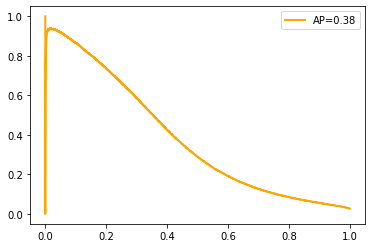

In [28]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import roc_curve
# from sklearn.metrics import RocCurveDisplay
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics
# import matplotlib.pyplot as plt
# import matplotlib
# import scipy.stats

# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42


# fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(chr1_binned["label"].astype(int), abs(chr1_binned["atac"]))
# roc_auc = metrics.average_precision_score(chr1_binned["label"], abs(chr1_binned["atac"]))
# plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='orange', label="AP="+str(round(roc_auc,2)))
# plt.legend()

In [20]:
#rom sklearn.metrics import roc_auc_score

In [21]:
# roc_auc_score(chr1_binned["label"],  abs(chr1_binned["atac"]))

0.8701539282294635

In [22]:
# import numpy as np
# from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(chr1_binned["label"], chr1_binned["atac"])
# auc = metrics.auc(fpr, tpr)

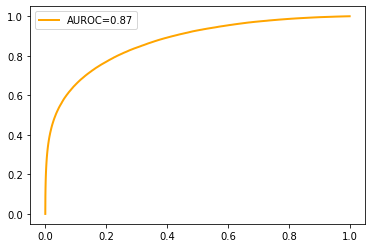

In [27]:
# plt.plot(fpr, tpr,  linewidth=2, c='orange', label="AUROC="+str(round(auc,2)))
# plt.legend()